In [1]:
# I want to create a dataset where elements are of the shape (6,6,4): a 6x6 spin glass grid in which any point is related to 4 numbers: the values of the connections from the spin to the four neighbors 

# import libraries
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import matplotlib as mpl

mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12


In [2]:
# initialize spin configuration
def create_initial_config(N=None):
    states = [-1., 1.]
    config = np.random.choice(states, (N, N))
    return config

In [3]:
def metropolis_single_update(config=None, T=None, J=None):

    # make sure config is square
    N, M = config.shape
    assert N == M, "Wrong configuration shape"

    # choose random site
    i = np.random.randint(N)
    j = np.random.randint(M)
    s =  config[i, j]

    # compute energy cost of flip
    # DeltaE is the possible energy cost
    # effDeltaE is the real energy cost (depending on whether we did the flip or not)
    DeltaE = 2*s*(J[i,j,0]*config[i,(j-1)%N] + J[i,j,1]*config[i,(j+1)%N] + J[i,j,2]*config[(i+1)%N, j] + J[i,j,3]*config[(i-1)%N, j])
    effDeltaE = 0

    # case DeltaE < 0, flip the spin with prob 1
    if DeltaE < 0:
        # flip the sping
        s *= -1
        # set effective DeltaE to DeltaE
        effDeltaE = DeltaE

    # case DeltaE >= 0
    else:
        # flip the spin with certain probability 
        if np.random.random() < np.exp(-DeltaE/T):
            # flip the sping
            s *= -1
            # set effective Delta E
            effDeltaE = DeltaE

    # update configuration
    # notice there is no need to return the whole configuration, the function
    # will modify config _in_place_
    config[i, j] = s

    # but it is clever to return the effective DeltaE, since we have already computed it
    # notice that if we didn't flip the spin, the change in energy is 0
    return effDeltaE

In [4]:
# create values to assign to connections (p is taken uniformly)
def crea_vettore(N, p):
    dim = (N-1)*N*2 # is the number of connections in NON periodic grid
    vettore = np.ones(dim, dtype=int)
    indici_negativi = np.random.choice(dim, p, replace=False)
    vettore[indici_negativi] = -1
    return vettore

In [5]:
def crea_spin_glass_dataset(N, v):
    # initialize zero tensor
    J = np.zeros((N, N, 4), dtype=int)
    count = 0
    # iter for any spin of the grid
    for i in range(N):
        for j in range(N):
            
            if j == 0:
                J[i, j, 0] = 0  # left border
            else:
                J[i, j, 0] = J[i, j-1, 1]  # left connection is equivalent to the right connection of the previous spin 

    
            if j == N-1:
                J[i, j, 1] = 0  # right border
            else:

                J[i, j, 1] = v[count] # take values from the previous created vector
                count = count + 1
            
            if i == 0:
                J[i, j, 2] = 0  # upper border
            else:
                J[i, j, 2] = J[i-1, j, 3]  # is equivalent to the down connection of the upper spin

            
            if i == N-1:
                J[i, j, 3] = 0  # lower border
            else:
                J[i, j, 3] = v[count]  # connection to the down spin
                count = count + 1
    return J

In [6]:
# EDWARDS ANDERSON ORDER PARAMETER
def compute_q_EA(config_history):
    N = config_history.shape[1]
    avg_spins = np.mean(config_history, axis=0)  # average on all configurations
    q_EA = np.sum(avg_spins ** 2) / (N * N)  # q_EA = (1/N) * sum(<sigma_i>^2)
    return q_EA

In [7]:
def compute_total_energy(config, J):
    N, M = config.shape
    total_energy = 0
    for i in range(N):
        for j in range(M):
            s = config[i, j]
            total_energy -= s * (J[i, j, 0] * config[i, (j-1)%N] +
                                 J[i, j, 1] * config[i, (j+1)%N] +
                                 J[i, j, 2] * config[(i+1)%N, j] +
                                 J[i, j, 3] * config[(i-1)%N, j])
    return total_energy / 2  # To account for double-counting

In [9]:
# PROVA
vettore = crea_vettore(6,2)
print(vettore)

[ 1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1]


In [8]:
# set parameters for the simulation annealing
N = 6
T_values = np.arange(4, 0, -0.1)
T_values = np.append(T_values, 0.1)
n_updates = 100000
num_combinations = 800

vec = list(range(0, (N-1) * N * 2 + 1))
data = []

for z in range(num_combinations):
    p = random.choice(vec) # uniform distribution
    print(z)
    v = crea_vettore(N, p)
    
    J = crea_spin_glass_dataset(N, v)
    config = create_initial_config(N)

    for T in T_values:
        total_energy_sum = 0
        config_history = []  # save configuration iteratively
        total_measurements = 0

        for k in range(n_updates):
            DeltaE = metropolis_single_update(config, T=T, J=J)
            if k > 10000 and k % 100 == 0:  # first 10000 steps are for convergence, then I compute the average energy of the following
                config_history.append(config.copy())  # save a copy of the configuration

                total_energy = compute_total_energy(config, J)
                total_energy_sum += total_energy
                total_measurements += 1

        average_energy = total_energy_sum / total_measurements
        # convert config_history in array numpy for computations
        config_history = np.array(config_history)
        q_EA = compute_q_EA(config_history)

        # save all in a dataset
        data.append({
            'J': J,
            'T': T,
            'energy': average_energy,
            'q_EA': q_EA
        })

# convert in DataFrame
df = pd.DataFrame(data)

# save dataset in a file
df.to_pickle('spin_glass_dataset.pkl')

print("Dataset salvato con successo!")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

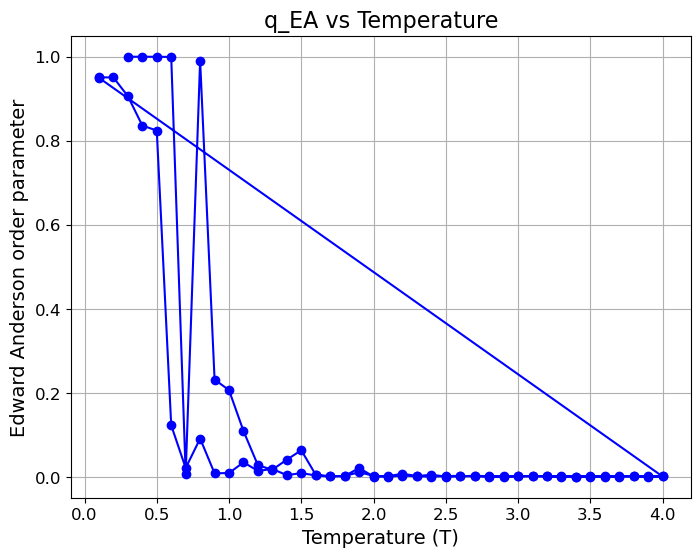

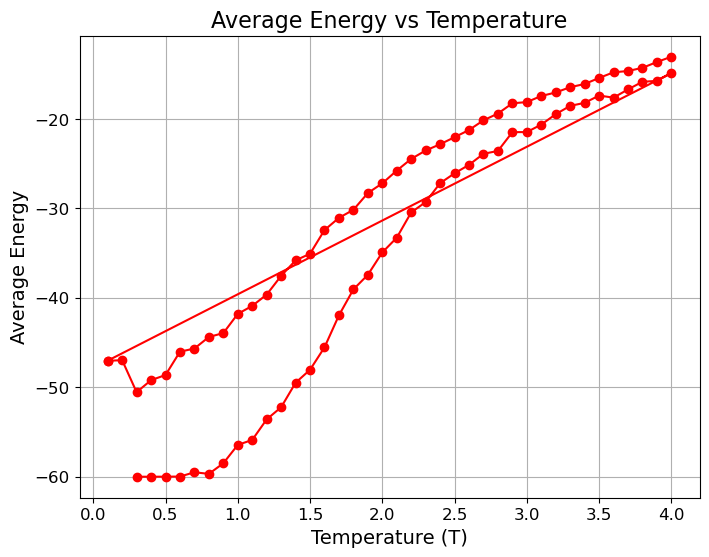

In [12]:
# load dataset
df = pd.read_pickle('spin_glass_dataset.pkl')
df = df[0:79]
# plot q_EA vs temperature
plt.figure(figsize=(8, 6))
plt.plot(df['T'], df['q_EA'], marker='o', linestyle='-', color='b')
plt.xlabel('Temperature (T)')
plt.ylabel('Edward Anderson order parameter')
plt.title('q_EA vs Temperature')
plt.grid(True)
plt.show()

# plot Average Energy vs temperature
plt.figure(figsize=(8, 6))
plt.plot(df['T'], df['energy'], marker='o', linestyle='-', color='r')
plt.xlabel('Temperature (T)')
plt.ylabel('Average Energy')
plt.title('Average Energy vs Temperature')
plt.grid(True)
plt.show()

In [9]:
import pandas as pd

# load dataset
data = pd.read_pickle('spin_glass_dataset.pkl')

# Numero di elementi nel dataset
print(f"Shape of element in the dataset: {data.iloc[0]['J'].shape}") 

Shape of element in the dataset: (6, 6, 4)
